## Imports

In [610]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import read
import pandas as pd
import math
import random

def checkNotEmpty(input_array):
    for x in input_array:
        if float(x) > 0:
            return True
    return False

def getAverage(input_array):
    acc = 0.0
    for x in input_array:
        acc+=x
    return acc / len(input_array)

def getWindowFrameFromDir(source_dir, window_size):
    cache_windows = []
    ipc_windows = []
    for subdir, dirs, files in os.walk(source_dir):
        for dir in dirs:
            cache = []
            ipc = []
            ipc_window = []
            cache_window= []
            for filename in os.listdir(os.path.join(subdir, dir)):
                f = os.path.join(subdir, dir, filename)
                actualfile = open(f,'r')
                if (filename[:3] == "ipc"):
                    ipc = actualfile.readlines()
                else:
                    cache = actualfile.readlines()
            dipc = window_size-len(ipc)
            dcache = window_size-len(cache)
            if dipc > 0:
                for x in range(dipc):
                    ipc.append('0')
            if dcache > 0:
                for x in range(dcache):
                    cache.append('0')
            if (checkNotEmpty(cache) and checkNotEmpty(ipc)):
                for x in range(0, window_size):
                    ipc_window.append(float(ipc[x]))
                for x in range(0, window_size):
                    # let's normalize cache access to IPC
                    cache_window.append(float(cache[x])/1000000)
                cache_windows.append(getAverage(cache_window))
                ipc_windows.append(getAverage(ipc_window))
    dataframe = pd.DataFrame(list(zip(ipc_windows, cache_windows)), columns=['avg_ipc', 'avg_cache'])
    return dataframe
def create_reference(df, label):
    data = []
    for x in df.index:
        data.append(label)
    return data

def false_negative_rate(reference, prediction):
  false_negatives = 0
  true_positives = 0
  
  for i in range(len(reference)):
    if reference[i] == -1 and prediction[i] == 1:
      false_negatives += 1
    elif reference[i] == -1:
      true_positives += 1
      
  false_negative_rate = false_negatives / (false_negatives + true_positives)
  
  return false_negative_rate

def false_positive_rate(reference, prediction):
  false_positives = 0
  true_negatives = 0
  
  for i in range(len(reference)):
    if reference[i] == 1 and prediction[i] == -1:
      false_positives += 1
    elif reference[i] == 1:
      true_negatives += 1
      
  false_positive_rate = false_positives / (false_positives + true_negatives)
  
  return false_positive_rate


def accuracy(reference, prediction):
    total = len(prediction) + 1
    matches = 0
    for i in range(total - 1):
        if reference[i] == prediction[i]:
            matches += 1
    return matches/total


def split_array(array):
    # Shuffle the array so that the split is random
    random.shuffle(array)

    # Find the midpoint of the array
    mid = len(array) // 2

    # Split the array into two halves
    first_half = array[:mid]
    second_half = array[mid:]

    return first_half, second_half

## Data frame construction

In [611]:
bench = "../results/benchmarks/" # change me if necessary
normal = "../results/pcf2bdf/normal/"
attack = "../results/pcf2bdf/attack/"
window_size = 50 # change me if necessary: 10 for custom, 50 for others

<AxesSubplot: xlabel='avg_ipc', ylabel='Probability'>

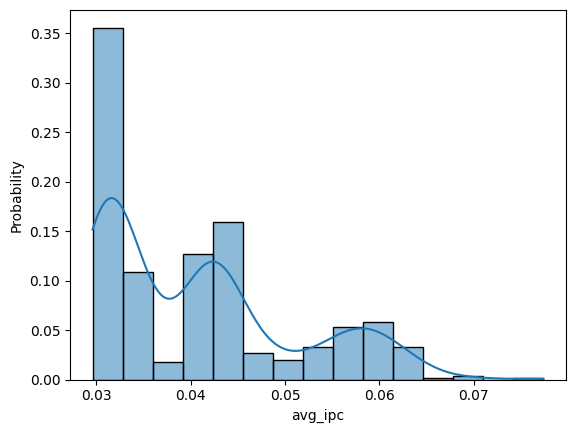

In [612]:
df_bench  = getWindowFrameFromDir(bench,window_size)
df_normal = getWindowFrameFromDir(normal,window_size)
df_attack = getWindowFrameFromDir(attack,window_size)
import seaborn as sns
sns.histplot(df_attack['avg_ipc'], kde=True, stat='probability')


## Unsupervised stuff

### Dataset visualization (normal data)

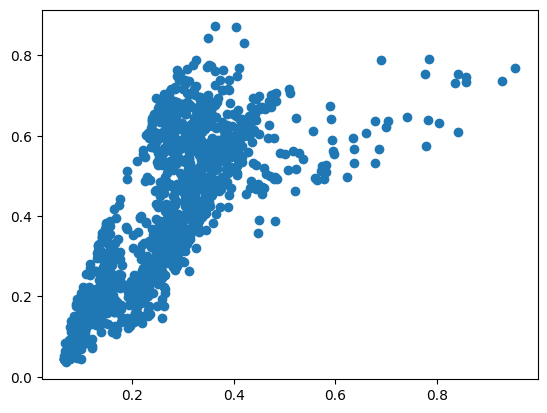

In [613]:
df_merged = pd.concat([df_normal], ignore_index=True)
x_axis = df_merged["avg_ipc"]  
y_axis = df_merged["avg_cache"]  

# Plotting
plt.scatter(y_axis, x_axis)
plt.show()

### One-class SVM

[Full set] Accuracy =  92.64 %, fp =  4.67 %, fn =  8.24 %


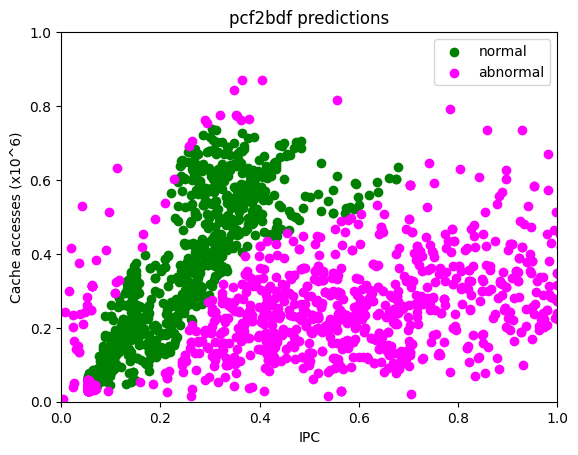

In [614]:
from sklearn import datasets
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split

X_train, X_eval = train_test_split(df_normal, shuffle = True,test_size=0.5)


clf = OneClassSVM(gamma='scale', kernel='rbf', nu=0.06).fit(X_train) #0.07
#TODO: explore nu value https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM.decision_function
Y_pred_attack = clf.predict(df_attack)
Y_pred_normal = clf.predict(X_eval)
Y_pred_bench = clf.predict(df_bench)

y_train_normal = create_reference(X_eval, 1)
y_train_attack = create_reference(df_attack, -1)
y_train_bench = create_reference(df_bench, -1)


y_train = np.concatenate([y_train_normal, y_train_attack, y_train_bench])
y_pred = np.concatenate([Y_pred_normal, Y_pred_attack, Y_pred_bench])
df_merged =  pd.concat([X_eval, df_attack, df_bench], ignore_index=True)
x_axis = df_merged["avg_ipc"]  
y_axis = df_merged["avg_cache"]  

x_norm, x_anorm, y_norm, y_anorm = [], [], [], []
for i in range (len(y_pred)):
    if y_pred[i] == 1:
        x_norm.append(x_axis[i])
        y_norm.append(y_axis[i])
    else:
        x_anorm.append(x_axis[i])
        y_anorm.append(y_axis[i])

print("[Full set] Accuracy = ", round(accuracy(y_train, y_pred)*100,2), "%, fp = ", round(false_positive_rate(y_train, y_pred)*100,2), "%, fn = ", round(false_negative_rate(y_train, y_pred)*100,2), "%")

# # Plotting
c1 = plt.scatter(y_norm, x_norm, c='green')
c2 = plt.scatter(y_anorm, x_anorm, c='magenta')
plt.legend([c1, c2], ['normal', 'abnormal'])
plt.xlim(0,1) #nolimit for tinyexr
plt.ylim(0,1) #2.5 for tinyexr, 1 for pcf2bdf
plt.xlabel("IPC")
plt.ylabel("Cache accesses (x10^6)")
plt.title("pcf2bdf predictions")
plt.show()
#plt.plot(y_train, c = 'magenta',  linestyle = 'None', marker='*')
#plt.plot(y_pred, c= 'cyan', linestyle='None', marker='3')
#plt.show()

### Local outlier factor (LOF)

[Full set] Accuracy =  93.5 %, fp =  5.68 %, fn =  6.74 %


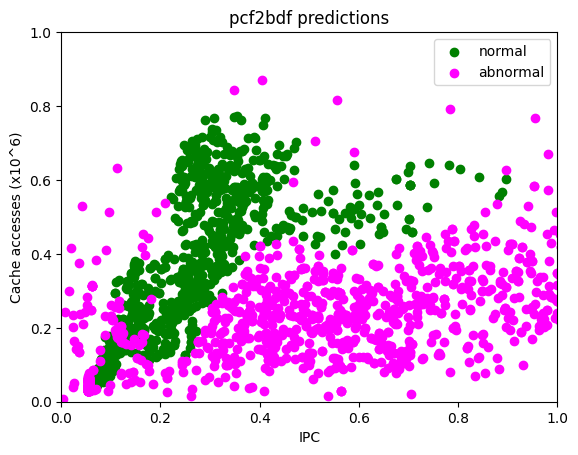

In [615]:
from sklearn import datasets
from sklearn import svm
from sklearn.neighbors import LocalOutlierFactor

X_train, X_eval = train_test_split(df_normal, shuffle = True,test_size=0.5)

lof = LocalOutlierFactor(novelty=True,n_neighbors=15) # change n_neighbors
lof.fit(X_train.values)

Y_pred_attack = lof.predict(df_attack)
Y_pred_normal = lof.predict(X_eval)
Y_pred_bench = lof.predict(df_bench)


y_train_normal = create_reference(X_eval, 1)
y_train_attack = create_reference(df_attack, -1)
y_train_bench = create_reference(df_bench, -1)


y_train = np.concatenate([y_train_normal, y_train_attack, y_train_bench])
y_pred = np.concatenate([Y_pred_normal, Y_pred_attack, Y_pred_bench])
df_merged =  pd.concat([X_eval, df_attack, df_bench], ignore_index=True)
x_axis = df_merged["avg_ipc"]  
y_axis = df_merged["avg_cache"]  

x_norm, x_anorm, y_norm, y_anorm = [], [], [], []
for i in range (len(y_pred)):
    if y_pred[i] == 1:
        x_norm.append(x_axis[i])
        y_norm.append(y_axis[i])
    else:
        x_anorm.append(x_axis[i])
        y_anorm.append(y_axis[i])

print("[Full set] Accuracy = ", round(accuracy(y_train, y_pred)*100,2), "%, fp = ", round(false_positive_rate(y_train, y_pred)*100,2), "%, fn = ", round(false_negative_rate(y_train, y_pred)*100,2), "%")

# # Plotting
c1 = plt.scatter(y_norm, x_norm, c='green')
c2 = plt.scatter(y_anorm, x_anorm, c='magenta')
plt.legend([c1, c2], ['normal', 'abnormal'])
plt.xlim(0,1) #nolimit for tinyexr, 1 pcf, 5 custom
plt.ylim(0,1) #2.5 for tinyexr, 1 for pcf2bdf, 0.5 custom
plt.xlabel("IPC")
plt.ylabel("Cache accesses (x10^6)")
plt.title("pcf2bdf predictions")
plt.show()